In [1]:
"""
Created on January 17
Group 4
Sub Group : Facet
@author : C.G  
"""

'\nCreated on January 17\nGroup 4\nSub Group : Facet\n@author : C.G  \n'

In [2]:
%run G4_facet_functions_VF.ipynb

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score
from sklearn.cluster import MiniBatchKMeans

# How we affect facet

Scores for facet baggage :  0.9989138626112144


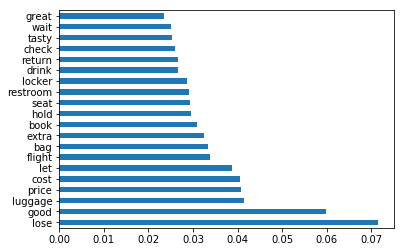

In [4]:
#To build the following dictionary we used this function and run it on each facet

words_facet('ALL_DATA_ANNOTATE', 'baggage')
#words_facet('ALL_DATA_ANNOTATE', 'atmosphere')
#words_facet('ALL_DATA_ANNOTATE', 'cabin_crew')
#words_facet('ALL_DATA_ANNOTATE', 'comfort')
#words_facet('ALL_DATA_ANNOTATE', 'food')
#words_facet('ALL_DATA_ANNOTATE', 'not_flight')
#words_facet('ALL_DATA_ANNOTATE', 'price')
#words_facet('ALL_DATA_ANNOTATE', 'punctuality')

In [5]:
dict_facets = {
    'baggage_facet': ['lose', 'let', 'bag', 'luggage', 'hand', 'people'],
    'atmosphere_facet': ['quiet', 'noise', 'calm', 'lounge', 'air'],
    'cabin_crew_facet': ['crew', 'cabin', 'helpful', 'professional', 'efficient', 'friendly'],
    'comfort_facet': ['seat', 'comfortable', 'legroom', 'room', 'leg', 'space', 'entertainment', 'uncomfortable'],
    'food_facet': ['food', 'meal', 'drink', 'snack', 'serve', 'beverage', 'tasty', 'wine', 'eat'],
    'not_flight_facet': ['check', 'boarding', 'customer', 'board', 'staff'],
    'price_facet': ['price', 'budget', 'cheap', 'cost', 'ticket', 'value', 'pay', 'reasonable'],
    'punctuality_facet': ['time', 'delay', 'arrival', 'arrive', 'late', 'schedule', 'departure']
}

# TF-IDF

In [6]:
tf_idf = pd.read_csv('../data/g4_tfidf_ALL_DATA_ANNOTATE.csv', index_col=0)
reference_file = pd.read_csv('../data/ALL_DATA_ANNOTATE_new_facets.csv', index_col=0)

## 1) Kmeans++

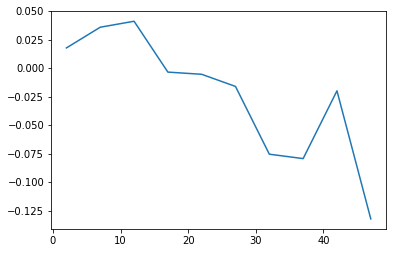

In [7]:
nb_clusters = []
silhouettes = []
for cluster in tqdm_notebook(range(2, 50, 5)):
    nb_clusters.append(cluster)
    silhouettes.append(silouhette_Kmeans_pp(cluster, tf_idf))
    
plt.plot(nb_clusters, silhouettes)

The silouhette measures the heterogeneity between clusters and thus to choose the right number of clusters.
A negative value means that the clusters intersect each other.

For this, we can take one of the highest values as an "optimal" cluster number.

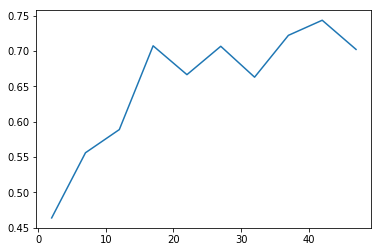

In [8]:
nb_clusters = []
purities = []
for cluster in tqdm_notebook(range(2, 50, 5)):
    nb_clusters.append(cluster)
    purities.append(purity_Kmeans_pp(tf_idf, cluster))
    
plt.plot(nb_clusters, purities)

Cluster purity measures the average homogeneity of clusters : 

    - For each cluster, we measure the proportion of majority elements in each cluster.
        Exp: Compo_Cluster1 = 3R, 7B -> purity = 0.7
        
    - Then the results are averaged.


By crossing the two graphs, we can choose to take 17 clusters: we have a purity close to the maximum observed and a silouhette score among the highest.

With the silouhette we also observe that exceeding 20 clusters is not necessarily useful (negative values).

Nevertheless the scores are not very high => the clusters have difficulty to differentiate themselves

In [9]:
#Prediction with 17 clusters
clusters = MiniBatchKMeans(n_clusters=17, random_state=42).fit(tf_idf)

In [10]:
centers = one_word_per_cluster(clusters, tf_idf)
keywords = get_keyword(centers, 20)
keyword_per_cluster = pd.DataFrame(keywords)

In [11]:
facets_predictions_kmeans_pp = facet_for_sentence(keyword_per_cluster, tf_idf.index, dict_facets, clusters.labels_, 'kmeans++', 'ALL_DATA_ANNOTATE')

In [12]:
reference_file_kmeans_pp = reference_file.loc[facets_predictions_kmeans_pp.index]
scores_kmeans_pp = []
for i in range(len(facets_predictions_kmeans_pp)):
    y_pred = list(facets_predictions_kmeans_pp.iloc[i])
    y_true = list(reference_file_kmeans_pp.iloc[i])
    scores_kmeans_pp.append(accuracy_score(y_pred, y_true))

np.mean(scores_kmeans_pp)

0.829877266547954

##  2) LDA method

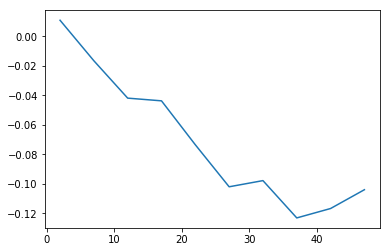

In [13]:
nb_clusters = []
silhouettes = []
for cluster in tqdm_notebook(range(2, 50, 5)):
    nb_clusters.append(cluster)
    silhouettes.append(silouhette_LDA(cluster, tf_idf))
    
plt.plot(nb_clusters, silhouettes)

By increasing the cluster number, the value of the silhouette decreases.

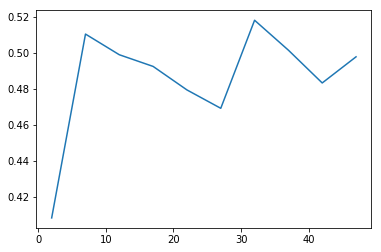

In [14]:
nb_clusters = []
purities = []
for cluster in tqdm_notebook(range(2, 50, 5)):
    nb_clusters.append(cluster)
    purities.append(purity_LDA(tf_idf, cluster))
    
plt.plot(nb_clusters, purities)

7 or 32 clusters appears to be the purity maximizing values for the LDA method.

In [15]:
top_words, cluster_prediction, facets_predictions_LDA = LDA_tfidf(17, 'ALL_DATA_ANNOTATE', dict_facets)

In [17]:
reference_file_LDA = reference_file.loc[facets_predictions_LDA.index]
scores_LDA = []
for i in range(len(facets_predictions_LDA)):
    y_pred = list(facets_predictions_LDA.iloc[i])
    y_true = list(reference_file_LDA.iloc[i])
    scores_LDA.append(accuracy_score(y_pred, y_true))

np.mean(scores_LDA)

0.7907739352606274

##  3) Classification 

In [18]:
facets_new= ['COMFORT','BAGGAGE','CABIN_CREW','ATMOSPHERE','EMPTY','FOOD','NOT_FLIGHT','PRICE','PUNCTUALITY']
dict_cluster=get_dict_cluster(tf_idf, n_clusters=17, n_terms=10)
dict_facets_new_ref = create_dict_new_facet(facets_new)
comments=pd.read_csv("../data/clean_sentences_ALL_DATA_ANNOTATE.csv",index_col=0)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version


In [19]:
facet_with_classification = df_doc_new_facet(facets_new, comments, dict_facets_new_ref, tf_idf, dict_cluster)

In [20]:
reference_file_classification = reference_file.loc[facet_with_classification.index]
scores_classification = []
for i in range(len(facet_with_classification)):
    y_pred = list(facet_with_classification.iloc[i])
    y_true = list(reference_file_classification.iloc[i])
    scores_classification.append(accuracy_score(y_pred, y_true))

np.mean(scores_classification)

0.5719072510387346

This method gives us a lower score because we tend to predict too many facets for each sentence.
<br>Our list of synonyms is probably a little too long...

##  4) Supervised test

In [21]:
list_facets=list(reference_file.columns)
for i in range(len(list_facets)):
    print(list_facets[i],"==> score=",facet_score(tf_idf,list_facets[i],reference_file))

atmosphere ==> score= 0.9805273134585559
baggage ==> score= 0.9989660520420472
cabin_crew ==> score= 0.7923142613151153
comfort ==> score= 0.6985069562266711
empty ==> score= 0.9333554927704836
food ==> score= 0.9264363998671538
not_flight ==> score= 0.9775933609958506
price ==> score= 0.9895435684647302
punctuality ==> score= 0.9756582215598609


It is noticeable that for some facets, supervised learning can give excellent results.<br>
However, for other facets, it is more difficult to predict.

# Word Embedding

In [22]:
embedding = pd.read_csv('../data/g4_embedding_ALL_DATA_ANNOTATE.csv', index_col=0)

## 1) Kmeans

In [23]:
data, index, comments = database_read("ALL_DATA_ANNOTATE")

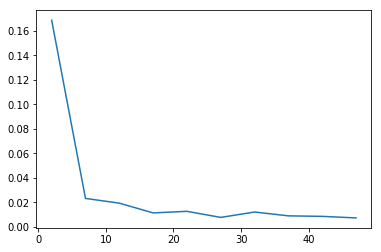

In [24]:
nb_clusters = []
silhouettes = []
for cluster in tqdm_notebook(range(2, 50, 5)):
    nb_clusters.append(cluster)
    silhouettes.append(silhouette_Kmeans(cluster, data))
    
plt.plot(nb_clusters, silhouettes)

This graph shows us the value of the silhouette as a function of the number of clusters.

The silhouette makes it possible to measure whether the clusters are well separated.

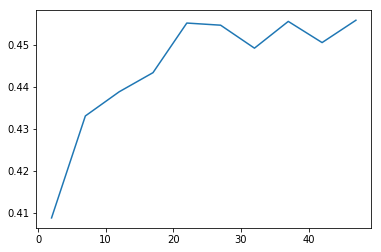

In [25]:
nb_clusters = []
purities = []
for cluster in tqdm_notebook(range(2, 50, 5)):
    nb_clusters.append(cluster)
    purities.append(purity_Kmeans(data, cluster))
    
plt.plot(nb_clusters, purities)

These graphs show us the purity value as a function of the number of clusters. <br>
Purity is a measure of the homogeneity of the clusters.<br>
Here, it is better to take 17 clusters. It is the number of clusters that is quite good in purity and silhouette tests.

In [26]:
matrix, words = cluster_embedding(data, index, comments, 17)

In [27]:
facets_predictions_kmeans_e = facet_for_sentence(words, embedding.index, 
                                                  dict_facets, list(matrix['cluster']), 
                                                  'kmeans_e', 'ALL_DATA_ANNOTATE')

In [28]:
reference_file_kmeans_e = reference_file.loc[facets_predictions_kmeans_e.index]
scores_kmeans_e = []
for i in range(len(facets_predictions_kmeans_e)):
    y_pred = list(facets_predictions_kmeans_e.iloc[i])
    y_true = list(reference_file_kmeans_e.iloc[i])
    scores_kmeans_e.append(accuracy_score(y_pred, y_true))

np.mean(scores_kmeans_e)

0.7278810261297752

# Weighted Word Embedding

In [29]:
weight_embedding = pd.read_csv('../data/g4_weight_embedding_ALL_DATA_ANNOTATE.csv', index_col=1)
weight_embedding = weight_embedding.iloc[:, 1:]

In [30]:
data, index, comments = database_read("ALL_DATA_ANNOTATE", weighted=True)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


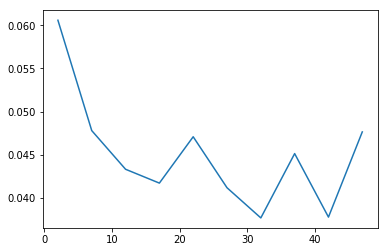

In [31]:
nb_clusters = []
silhouettes = []
for cluster in tqdm_notebook(range(2, 50, 5)):
    nb_clusters.append(cluster)
    silhouettes.append(silhouette_Kmeans(cluster, data))
    
plt.plot(nb_clusters, silhouettes)

The closer the coordinates of the documents of each cluster are to the centre of gravity of each cluster, the more relevant the silhouette will be

 If two clusters are too close to each other the silhouette may be skewed
 The silhouette coefficient contrasts the average distance to elements in the same cluster with the average distance to elements in other clusters. Objects with a high silhouette value are considered well clustered, objects with a low value may be outliers. This index works well with k-means clustering, and is also used to determine the optimal number of clusters.

 The silhouette can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance.







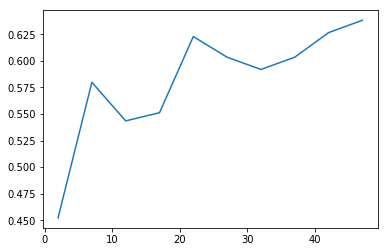

In [32]:
nb_clusters = []
purities = []
for cluster in tqdm_notebook(range(2, 50, 5)):
    nb_clusters.append(cluster)
    purities.append(purity_Kmeans(data, cluster))
    
plt.plot(nb_clusters, purities)

 The purity defines the rate of comments belonging to the dominant label weighted for each cluster. 

 Purity looks at the dominant label of each cluster and calculates the proportion of comments belonging to a label compared to the number of comments in that cluster

 For each cluster we count the number of documents from the most common class in said cluster and we divide the sum by the total number of reviews <br>
 High purity is easy to achieve when the number of clusters is large - in particular, purity is 1 if each document gets its own cluster. Thus, we cannot use purity to trade off the quality of the clustering against the number of clusters.<br>
 Also purity doesn't work well for imbalanced data : if a size 1000 dataset consists of two classes : problemes <br>
 Allows us to say if our labels are correct <br>
 Purity is a simple and transparent evaluation measure. Normalized mutual information can be information-theoretically interpreted

https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html

In [33]:
matrix, words = cluster_embedding(data, index, comments, 17)

In [34]:
facets_predictions_kmeans_we = facet_for_sentence(words, list(matrix['index']), 
                                                  dict_facets, list(matrix['cluster']), 
                                                  'kmeans_we', 'ALL_DATA_ANNOTATE')

In [35]:
reference_file_kmeans_we = reference_file.loc[facets_predictions_kmeans_we.index]
scores_kmeans_we = []
for i in range(len(facets_predictions_kmeans_we)):
    y_pred = list(facets_predictions_kmeans_we.iloc[i])
    y_true = list(reference_file_kmeans_we.iloc[i])
    scores_kmeans_we.append(accuracy_score(y_pred, y_true))

np.mean(scores_kmeans_we)

0.7291516027958544

# END